# Forecasting Apple Stock Price

In this project, I will build a Long short-term memory (LSTM) model to predict the future stock prices of Apple Company (AAPL), based on its stock prices of the past 10 years. LSTM is an artificial recurrent neural network that has feedback connections. 

The data for this project can be downloaded from [here](https://finance.yahoo.com/quote/AAPL/history?p=AAPL&.tsrc=fin-srch). I downloaded the data from 09/01/2010 to 09/30/2020. There are 2,538 tuples in the dataset, each representing a day's stock market attributes for Apple

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import Callback, EarlyStopping
from keras import optimizers

Using TensorFlow backend.


In [2]:
df = pd.read_table("AAPL.csv", delimiter=",")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-09-01,8.838214,8.980714,8.795714,8.940357,7.725714,697037600
1,2010-09-02,8.973572,9.006071,8.877500,9.006071,7.782502,415427600
2,2010-09-03,9.110357,9.242143,9.089286,9.241786,7.986192,520788800
3,2010-09-07,9.165714,9.268929,9.151786,9.207500,7.956563,342557600
4,2010-09-08,9.277857,9.442500,9.253572,9.390000,8.114268,526551200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2538 entries, 0 to 2537
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2538 non-null   object 
 1   Open       2538 non-null   float64
 2   High       2538 non-null   float64
 3   Low        2538 non-null   float64
 4   Close      2538 non-null   float64
 5   Adj Close  2538 non-null   float64
 6   Volume     2538 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 138.9+ KB


# Data Preprocessing

* Covert data type of ``Date`` to ``pd.date_time``
* Sort data by ``Date`` (the raw data should be sorted already, but just in case)
* Extract features

In [5]:
df.set_index(pd.to_datetime(df['Date']), inplace=True)
df.sort_index(ascending=True, inplace=True)

In [6]:
features = ["Open", "High", "Low", "Close", "Volume"]
df = df[features]

# Data Visualization

It's always a good idea to visualize your data first

Text(0, 0.5, 'stock price')

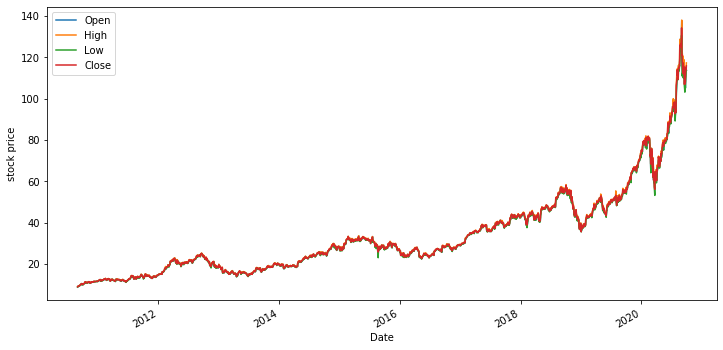

In [7]:
df.drop(["Volume"], axis=1).plot(figsize=(12,6))
plt.ylabel("stock price")

Text(0, 0.5, 'traded volume')

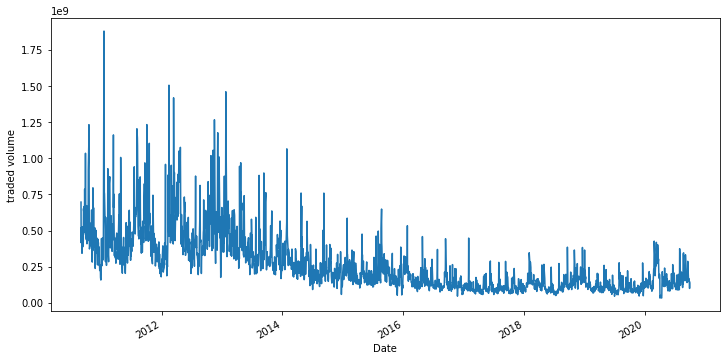

In [8]:
df["Volume"].plot(figsize=(12,6))
plt.ylabel("traded volume")

You can see there are quite some surges in the number of transactions on and before 2014. Let's take a look at the most extreme one.

In [9]:
df.iloc[np.argmax(df["Volume"]),:]

Open      1.176857e+01
High      1.231286e+01
Low       1.164286e+01
Close     1.216607e+01
Volume    1.880998e+09
Name: 2011-01-18 00:00:00, dtype: float64

Via a Google search, we found out that this sucess is led by the fact that Apple company sold 7.3 million iPads in the quarter. Based on this [CNN blog](https://money.cnn.com/2011/01/18/technology/apple_earnings/index.htm), this result was "surpassing the expectations of nearly every Wall Street analyst." 

# Data Preparation

There are a few steps need to be done to build a LSTM model

### Spliting and normalizing data

In [10]:
train, test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
sc = MinMaxScaler(feature_range=(0,1))
train = sc.fit_transform(train.values)
test = sc.transform(test.values)
print("We have", len(train), "train data samples and", len(test), "test data samples.")
print("The test data later will be splitted into an evaluation set and a test set")

We have 2030 train data samples and 508 test data samples.
The test data later will be splitted into an evaluation set and a test set


### Constructing time-series data

In [11]:
def make_timeseries_data(data, look_back, y_col=3):
    X, Y = [], []
    for i in range(len(data)-look_back):
        x = data[i:(i+look_back)]
        y = data[i+look_back, y_col]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

### Triming data

In [12]:
def trim_for_batch(data, batch_size):
    num_rows_to_drop = data.shape[0] % batch_size
    if num_rows_to_drop>0:
        data = data[:-num_rows_to_drop]
    return data

We will forecast a day's close stock price for AAPL using data from the previous 30 days. For example, use data from 1st April 2020 to 30 April 2020 to predict the close price on 1st May 2020. Therefore, each training sequence has a length of 30

In [13]:
LOOK_BACK = 30
BATCH_SIZE = 50

x_train, y_train = make_timeseries_data(train, LOOK_BACK)
x_train = trim_for_batch(x_train, BATCH_SIZE)
y_train = trim_for_batch(y_train, BATCH_SIZE)

x_temp, y_temp = make_timeseries_data(test, LOOK_BACK)
x_val, x_test = np.split(trim_for_batch(x_temp, BATCH_SIZE), 2)
y_val, y_test = np.split(trim_for_batch(y_temp, BATCH_SIZE), 2)

# Model Building

We only have 2,538 entries in the data, so we will build a shallow network that has one LSTM layer and one Dense layer. Building a deep network is prone to overfitting, and given the data size, it's likely to be starved.

In [14]:
model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

# Model Training

In [15]:
# customize callback function
class Evaluate(Callback):
    def __init__(self, x_val, y_val):
        self.best = 1e9
        self.x_val = x_val
        self.y_val = y_val
        
    def evaluate(self):
        val_pred = model.predict(self.x_val, verbose=1)
        val_pred = val_pred.flatten()
        score = mse(self.y_val, val_pred)
        return score

    def on_epoch_end(self, epoch, logs=None):
        score = self.evaluate()
        if score < self.best:
            self.best = score
            model.save_weights("best_model.weights")
        print("current mse: %.4f, best mse: %.4f\n" % (score, self.best))

In [16]:
evaluator = Evaluate(x_val, y_val)

history = model.fit(x_train, y_train, 
                    epochs=40, 
                    batch_size=BATCH_SIZE, 
                    shuffle=False,
                    validation_data=(x_val, y_val),  
                    callbacks=[evaluator]
                ) 

Train on 2000 samples, validate on 225 samples
Epoch 1/40
225/225 [==============================] - 0s 1ms/step
current mse: 0.0014, best mse: 0.0014

Epoch 2/40
225/225 [==============================] - 0s 406us/step
current mse: 0.0023, best mse: 0.0014

Epoch 3/40
225/225 [==============================] - 0s 419us/step
current mse: 0.0008, best mse: 0.0008

Epoch 4/40
225/225 [==============================] - 0s 499us/step
current mse: 0.0008, best mse: 0.0008

Epoch 5/40
225/225 [==============================] - 0s 428us/step
current mse: 0.0008, best mse: 0.0008

Epoch 6/40
225/225 [==============================] - 0s 419us/step
current mse: 0.0009, best mse: 0.0008

Epoch 7/40
225/225 [==============================] - 0s 418us/step
current mse: 0.0008, best mse: 0.0008

Epoch 8/40
225/225 [==============================] - 0s 424us/step
current mse: 0.0007, best mse: 0.0007

Epoch 9/40
225/225 [==============================] - 0s 423us/step
current mse: 0.0008, best mse: 

225/225 [==============================] - 0s 413us/step
current mse: 0.0006, best mse: 0.0005



Plot train loss and test loss to see if our model is overfitting

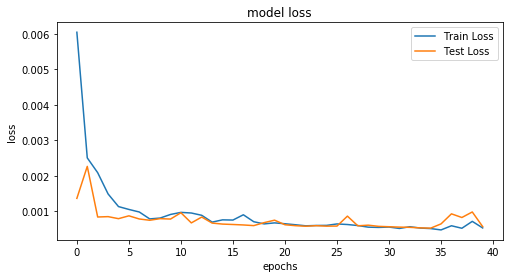

In [17]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

# Forecasting

In [18]:
model.load_weights("best_model.weights")

y_pred = model.predict(trim_for_batch(x_test, BATCH_SIZE), batch_size=BATCH_SIZE)

# Model Performance Evaluation

In [19]:
y_pred = y_pred.flatten()
y_test = trim_for_batch(y_test, BATCH_SIZE)
error = mse(y_test, y_pred)
print("The MSE is", error)

The MSE is 0.0018718373559596818


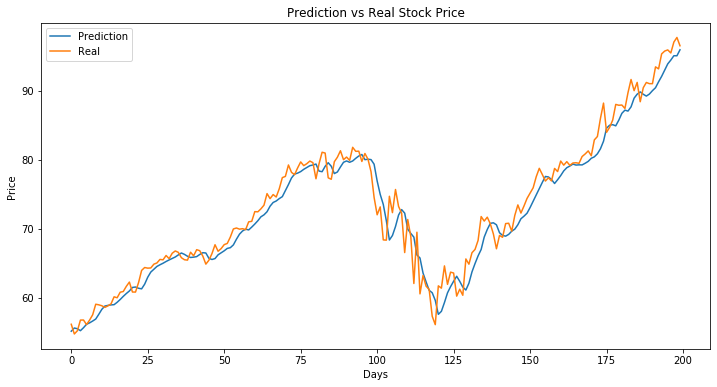

In [20]:
y_pred_org = (y_pred * sc.data_range_[3]) + sc.data_min_[3]
y_test_org = (y_test * sc.data_range_[3]) + sc.data_min_[3]

plt.figure(figsize=(12,6))
plt.plot(y_pred_org)
plt.plot(y_test_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()